In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

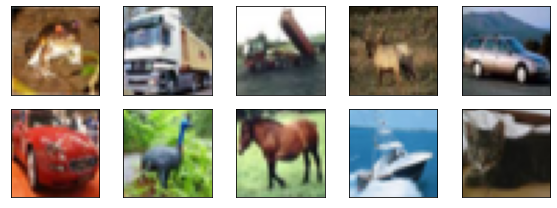

In [0]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

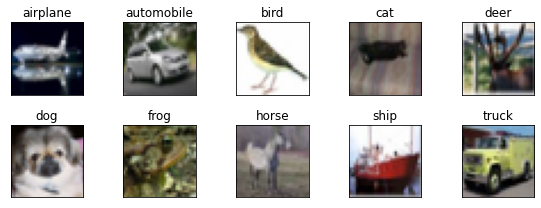

In [0]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [0]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


In [0]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [0]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)        

In [0]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [0]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)        

In [0]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [0]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [0]:
d_g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


epoch = 1/100, d_loss=0.390, g_loss=5.155                                                                                                     


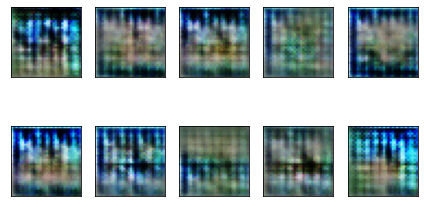

epoch = 2/100, d_loss=0.396, g_loss=1.038                                                                                                     
epoch = 3/100, d_loss=0.192, g_loss=0.552                                                                                                     
epoch = 4/100, d_loss=0.223, g_loss=2.698                                                                                                     
epoch = 5/100, d_loss=0.222, g_loss=1.052                                                                                                     
epoch = 6/100, d_loss=0.188, g_loss=2.100                                                                                                     
epoch = 7/100, d_loss=0.191, g_loss=4.705                                                                                                     
epoch = 8/100, d_loss=0.366, g_loss=5.301                                                                                                     

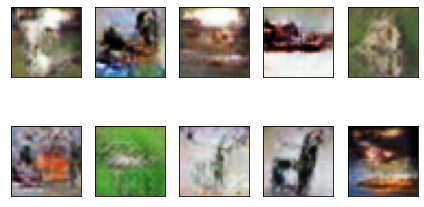

epoch = 12/100, d_loss=0.329, g_loss=4.654                                                                                                     
epoch = 13/100, d_loss=0.207, g_loss=4.505                                                                                                     
epoch = 14/100, d_loss=0.229, g_loss=4.812                                                                                                     
epoch = 15/100, d_loss=0.277, g_loss=3.330                                                                                                     
epoch = 16/100, d_loss=0.666, g_loss=5.037                                                                                                     
epoch = 17/100, d_loss=0.440, g_loss=5.390                                                                                                     
epoch = 18/100, d_loss=0.181, g_loss=5.353                                                                                              

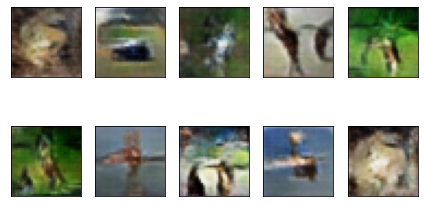

epoch = 22/100, d_loss=0.213, g_loss=4.678                                                                                                     
epoch = 23/100, d_loss=0.179, g_loss=5.043                                                                                                     
epoch = 24/100, d_loss=0.246, g_loss=4.400                                                                                                     
epoch = 25/100, d_loss=0.239, g_loss=3.785                                                                                                     
epoch = 26/100, d_loss=0.473, g_loss=2.141                                                                                                     
epoch = 27/100, d_loss=0.397, g_loss=3.555                                                                                                     
epoch = 28/100, d_loss=0.284, g_loss=2.310                                                                                              

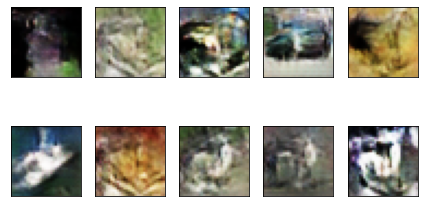

epoch = 32/100, d_loss=0.208, g_loss=5.141                                                                                                     
epoch = 33/100, d_loss=0.178, g_loss=7.121                                                                                                     
epoch = 34/100, d_loss=0.201, g_loss=5.331                                                                                                     
epoch = 35/100, d_loss=0.190, g_loss=4.305                                                                                                     
epoch = 36/100, d_loss=0.199, g_loss=4.926                                                                                                     
epoch = 37/100, d_loss=0.200, g_loss=4.853                                                                                                     
epoch = 38/100, d_loss=0.186, g_loss=5.931                                                                                              

KeyboardInterrupt: ignored

In [0]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

In [0]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()